<a href="https://colab.research.google.com/github/NicoleNisbett/IC2S2/blob/main/NYU_Data_collection_and_transformer_models_July2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Automatic data collection and transformer models workshop

July 26th 2022


Department of Psychology, NYU

---


Daniel Valdenegro `@dhvalden`

Nicole Nisbett `@nicolenisbett`


##Part one: Data collection
In this section we will introduce the use of Python programming language for automatic data collection from web sources. As an introductory example we will use the Academic API provided by Twitter for data collection of tweets. This section will include:
1. Installation and setup of Python and the necessary libraries in the user's machines.
2. Connecting to the Twitter Academic API and perform a sample request.
3. Inspect and Save the response delivered by the Twitter Academic API.




In [ ]:
!pip install tweepy==4.10

###Connect to Twitter's API



Select the tweets to capture based on keyword searches or hashtags. Tweets posted between specific dates or from specific accounts can also be selected. 

*Note: Use these access tokens for the purposes of the tutorial, but you can request your own through [Twitter Academic API](https://developer.twitter.com/en/products/twitter-api/academic-research/application-info)*


In [ ]:
import pandas as pd
import tweepy
import json

access_token = '390226670-6pdiACSOn19d8jgQ1U2VW9UwY9lB8VVa6HK2cbL8'
access_token_secret = 'e6G8lSSUZ03GaP8YNdiMBt6QeYGPfLumVsR0oHvThitZT'
consumer_key = 'ywZtkJpBLFJd9p1mj91jscIGF'
consumer_secret = 'UP5DLGhkaSxNMX8A9J4uH27Rijot8QNIyYOFwOwaBmNbgnFecM'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAABeE1wAAAAAA7pGX8cnp7IAgwcEPdSIWd5HjkoI%3DGM3UTdAwA9TkOI0AQqe69S8asZz927eeHk0kEme1Tu6cwZByYR'

client = tweepy.Client(bearer_token=bearer_token,
                       consumer_key=consumer_key,
                       consumer_secret=consumer_secret,
                       access_token=access_token,
                       access_token_secret=access_token_secret)

id = '807095'

with open('output.json', 'w') as f:
    for tweet in tweepy.Paginator(client.get_users_tweets,
                                  id=id,
                                  tweet_fields=['public_metrics',
                                                'created_at'],
                                  max_results=100).flatten(limit=100):
                                  
                                  json.dump(tweet.data, f)
                                  f.write('\n')

###Perform a request and save the results

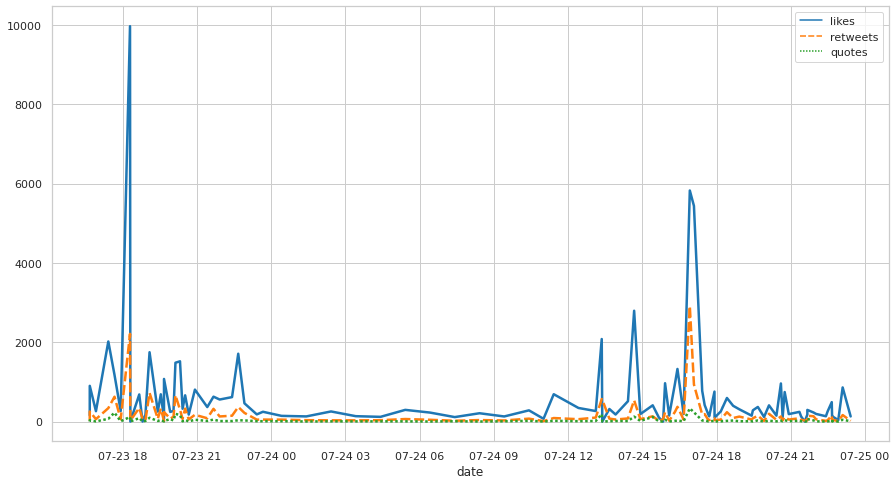

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

records = []

with open('output.json', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        record = {}
        record['text'] = tweet['text']
        record['date'] = tweet['created_at']
        record['id'] = tweet['id']
        record['likes'] = tweet['public_metrics']['like_count']
        record['retweets'] = tweet['public_metrics']['retweet_count']
        record['quotes'] = tweet['public_metrics']['quote_count']
        record['replies'] = tweet['public_metrics']['reply_count']
        records.append((record))

data = pd.DataFrame.from_records(records)

data['date'] = pd.to_datetime(data.date)
data = data.set_index('date')

sns.set_theme(style="whitegrid")

to_plot = data[['likes', 'retweets', 'quotes']]
plt.figure(figsize=(15,8))
sns.lineplot(data=to_plot, palette="tab10", linewidth=2.5,)
plt.show()

##Part two: Text data analysis.
In this section we will introduce the basic concepts of Natural Language Processing and how a researcher can gain knowledge from unstructured text data. In addition, we will have a hand on example of analysis of text processing and topic detection using the latest developments in the field of Transformers models. This section will include:
1. Ingestion and cleaning of the data collected from twitter.
2. General review of the collected data using text metrics.
3. Introduction to the concept of topic detection.
4. Use of BERTopic library to perform topic detection in the collected tweets.
All analysis will be completed using open-source python libraries, and code will be made available on GitHub.


###1. Clean the tweets scraped through the API


Now run the cleaning functions on the tweets and return a dataframe with the cleaned text

In [ ]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import preprocessor as p

def process_data(data):
    df=pd.read_csv(data)
    dfEN = df[df.lang == 'en'] #keep just the english tweets
    result2 = dfEN.loc[dfEN["sourcetweet_type"]!="retweeted"].copy()
    result2 = result2.sample(5000).copy()
    result3 = result2[['tweet_id',"text", "like_count", "retweet_count"]].copy()
    tweets = result2["text"].to_list()
    p.set_options(p.OPT.URL, p.OPT.RESERVED)
    tweetlist=[]
    for i in range(0,len(tweets)):
            tweetlist.append(p.clean(tweets[i]))
    return (tweetlist, result3)

tweetslist1, tweets1 = process_data("tweetsCOP25.csv")



###Set the parameters for the BERTopic algorithm

In [ ]:
!pip install bertopic


In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

# preprocess and clean data
my_stopwords = list(["rt","RT", "&", "amp", "&amp", "http","https", "http://", "https://", "fav", "FAV"])
new_stopwords = frozenset(list(text.ENGLISH_STOP_WORDS) + my_stopwords)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words = new_stopwords, min_df=5)

# do the BERT topic modelling

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

hdbscan_model = HDBSCAN(min_cluster_size= 20, metric='euclidean', cluster_selection_method='eom', prediction_data=True, min_samples=5)

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(tweetslist1)

In [ ]:
#run the model
topic_model = BERTopic(nr_topics = 10, umap_model=umap_model, hdbscan_model=hdbscan_model, embedding_model = sentence_model,vectorizer_model=vectorizer_model, low_memory=True, calculate_probabilities=True)

topics, probs = topic_model.fit_transform(tweetslist1, embeddings)


###Explore the model output

Get a list of topics with the number of documents (tweets) in each

In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name
0,-1,3414,-1_cop25_climate_change_action
1,0,281,0_madrid_cop25_live_climate
2,1,215,1_latest_thanks_daily_cop25 latest
3,2,180,2_energy_solar_cop25_power
4,3,171,3_youth_young_young people_climate
5,4,138,4_civil_civil society_activists_society
6,5,130,5_greta_thunberg_greta thunberg_gretathunberg
7,6,120,6_science_cop25cl_emergency_climate emergency
8,7,119,7_eu_timmermanseu_eugreendeal_green
9,8,118,8_indigenous_protest_leaders_cop25 madrid


Visualise the most common words associated with each topic

In [ ]:
topic_model.visualize_barchart()


Visualise the topics to explore the words in each topic and how close or distant they are to each other in terms of word similarity

In [ ]:
topic_model.visualize_documents(tweetslist1, embeddings=embeddings)

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_representative_docs(2)

['With the COP25 behind us and the EU going carbon neutral by 2050, it is now more crucial than ever to talk about the solutions that will allow the energy transition. Read more in our latest blog post: → #Lightyear #sustainability #impactinvesting',
 'We’re reducing our energy consumption by improving the energy efficiency of our processes and switching to renewable energy. Find out much more here: #COP25',
 'Sustainable energy holds the key to reducing emissions &amp; tackling climate change. \U0001fa7a Better health 👩\u200d🏭 More jobs 💰 Less poverty 👨🏿\u200d🎓 Access to education The solutions exist. Innovators like @EcozenSolutions need finance &amp; improved policies to grow. #COP25 #EnergyDay #SDG7',
 'Spain will phase out coal by 2030. The country sees no reason to compensate coal companies. "The companies have known for a long time that coal is coming to an end," said Spanish Environment Minister @Teresaribera at #COP25 in Madrid. #TimeToAct',
 '"Coal use is growing in China and

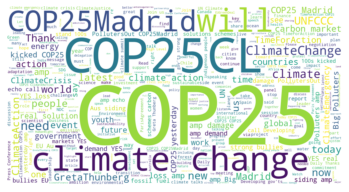

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud3(docs):
    text = (" ").join(docs)
    wc = WordCloud(width = 1500, height = 800, background_color="white", max_words=5000, min_font_size = 10)
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

create_wordcloud3(tweetslist1)

## Part 3: Classification

In [ ]:
! pip install datasets transformers

In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")

In [ ]:
imdb["test"][0]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_imdb = imdb.map(preprocess_function, batched=True)


In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

In [ ]:
from transformers import pipeline
pipe = pipeline("text-classification", model='./results/checkpoint-500')
pred = pipe("This restaurant is crap", verbose=False)

In [ ]:
pred